In [ ]:
!pip install datasets transformers torch torchvision tqdm

# Install the main transformers library from GitHub
!pip install git+https://github.com/huggingface/transformers.git@main

# Install necessary libraries from PyPI
!pip install -q datasets
!pip install -q nltk
!pip install -q evaluate  # HuggingFace's evaluation library
!pip install -q rouge_score  # Required for ROUGE metric



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-j9_70cbd
  Running command git clone --filter=blob:none --quiet 

## **Training of BLIP on Rad-VQA**

# Importing all relevant packages

In [ ]:
from datasets import load_dataset
import torch
import io
import pickle
import pandas as pd
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import os
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preparing data for training

In [ ]:
# Load the dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")

# Custom dataset class
class VQADataset(torch.utils.data.Dataset):
    """VQA dataset."""

    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get question and answer
        question = self.dataframe.iloc[idx]['question']
        answer = self.dataframe.iloc[idx]['answer']
        image_bytes = self.dataframe.iloc[idx]['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Process the image and question
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")

        # Tokenize the answer
        labels = self.processor.tokenizer.encode(
            answer, max_length=8, padding="max_length", truncation=True, return_tensors='pt'
        )
        encoding["labels"] = labels.squeeze()

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding

# Check available splits and handle datasets , Converting the dataset to pandas DataFrame
if "validation" in dataset.keys():
    val_df = dataset['validation'].to_pandas()
    train_df = dataset['train'].to_pandas()
else:
    # If no validation split is available, create one from the train split
    train_df_full = dataset['train'].to_pandas()
    # Filter for yes/no questions
    train_df_full = train_df_full[train_df_full['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)
    train_df, val_df = train_test_split(train_df_full, test_size=0.1, random_state=42)
    print("No validation split found, created own validation set.")

# Filter for yes/no questions for each dataset
train_df = train_df[train_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)
val_df = val_df[val_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

(…)-00000-of-00001-eb8844602202be60.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e5bc3d208bb4deeb.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

No validation split found, created own validation set.


# Preparing the training setup

In [ ]:
# Initialize model and processor
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

#Define the device , Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Empty cache and set manual seed
torch.cuda.empty_cache()
torch.manual_seed(42)

# Create datasets and dataloaders
train_dataset = VQADataset(dataframe=train_df, processor=processor)
valid_dataset = VQADataset(dataframe=val_df, processor=processor)

batch_size = 4  # Reduced batch size for memory efficiency
accumulation_steps = 4  # Gradient accumulation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training settings
num_epochs = 7
patience = 3
min_eval_loss = float("inf")
early_stopping_hook = 0
scaler = torch.cuda.amp.GradScaler()

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

<ipython-input-4-39cdbbcd7df5>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
tracking_information = []
# Training loop

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / accumulation_steps
        scaler.scale(loss).backward()
        epoch_loss += loss.item()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    # Validation loop
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validating"):
            input_ids = batch.pop('input_ids').to(device)
            pixel_values = batch.pop('pixel_values').to(device)
            attention_mask = batch.pop('attention_mask').to(device)
            labels = batch.pop('labels').to(device)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
            eval_loss += outputs.loss.item()

    tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print(f"Epoch {epoch + 1}: Training Loss = {epoch_loss / len(train_dataloader)}, Validation Loss = {eval_loss / len(valid_dataloader)}")
    scheduler.step()

    # saving model with lowest validation loss
    if eval_loss < min_eval_loss:
        model.save_pretrained("blip-saved-model")
        print("Model saved!")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook >= patience:
            print("Early stopping.")
            break

# saving training information
pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process is done!")


Validating: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]


Epoch 1: Training Loss = 1.8591232744027983, Validation Loss = 7.258474826812744
Model saved!


Validating: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s]


Epoch 2: Training Loss = 1.367532583621313, Validation Loss = 1.9459954698880513
Model saved!


Validating: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


Epoch 3: Training Loss = 0.15660217986002845, Validation Loss = 0.1677012670164307
Model saved!


Validating: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


Epoch 4: Training Loss = 0.024825552140169266, Validation Loss = 0.12342361221089959
Model saved!


Validating: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


Epoch 5: Training Loss = 0.015439062100343124, Validation Loss = 0.11225180661616226
Model saved!


Validating: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


Epoch 6: Training Loss = 0.011354198029159376, Validation Loss = 0.10893205739557743
Model saved!


Validating: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]

Epoch 7: Training Loss = 0.009161957925106486, Validation Loss = 0.12901329928232977
The finetuning process is done!


# Plotting train and eval loss

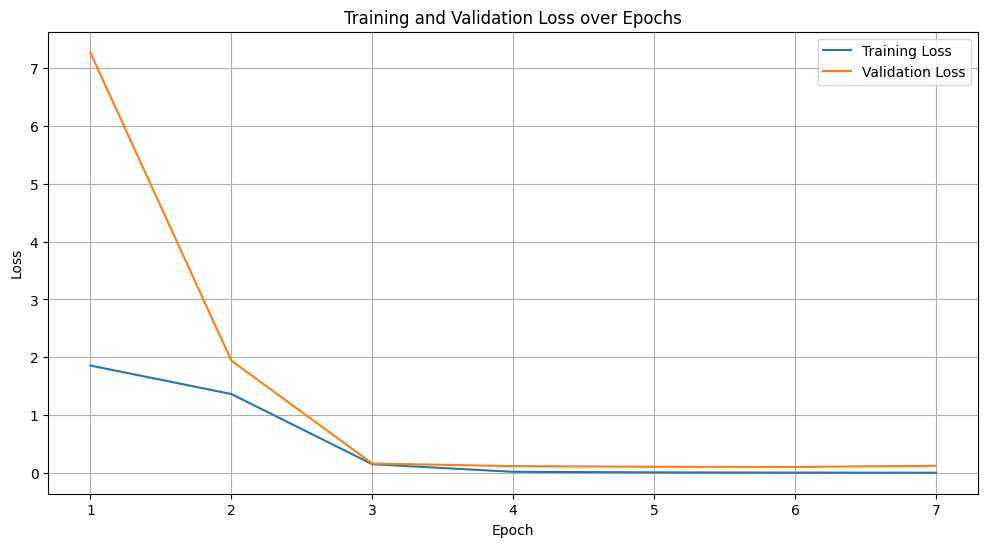

In [ ]:
# Load the tracking information directly from the pickle file
with open("/content/tracking_information.pkl", "rb") as file:
    tracking_information = pickle.load(file)

# Convert the tracking information (list of tuples) into a DataFrame
df = pd.DataFrame(tracking_information, columns=['Training Loss', 'Validation Loss', 'Learning Rate'])

# Extracting the training and validation loss
train_loss = df['Training Loss']
val_loss = df['Validation Loss']

# Plotting the training and validation loss with x-axis starting at 1
plt.figure(figsize=(12, 6))
plt.plot(df.index + 1, train_loss, label='Training Loss')
plt.plot(df.index + 1, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Saving fine-tuned model

In [ ]:
model.save_pretrained("Model/blip-saved-model_final")

## **Inference on Path_VQA test set**

Doing inference on Path_VQA test set using the latest model and writing predictions and labels into csv.

In [ ]:
# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("/content/Model/blip-saved-model_final").to("cuda")

dataset = load_dataset("flaviagiammarino/vqa-rad")

# Convert the test dataset to pandas DataFrame and filter yes/no answers
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Create a list to store the results
results = []

# Iterate through each row in the test DataFrame
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to("cuda")

    # Perform inference
    out = model.generate(**encoding)
    generated_text = processor.decode(out[0], skip_special_tokens=True)

    # Append results using the index as the identifier
    results.append((idx, actual_answer, generated_text))

Processing: 100%|██████████| 251/251 [00:28<00:00,  8.79it/s]


In [ ]:
# Write the results to a CSV file
csv_file_path = "/content/sample_data/results_final.csv"
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["ID", "Actual Answer", "Generated Answer"])  # Write header
    csv_writer.writerows(results)

print(f"Results saved to {csv_file_path}")

Results saved to /content/sample_data/results_final.csv


## **Evaluation**


Evaluating test

In [ ]:
# Metrics
def calculate_metrics(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Ensure the labels are consistent
    actual = df['Actual Answer'].str.strip().str.lower()
    predicted = df['Generated Answer'].str.strip().str.lower()

    # Convert answers to binary labels
    actual_labels = actual.apply(lambda x: 1 if x == 'yes' else 0)
    predicted_labels = predicted.apply(lambda x: 1 if x == 'yes' else 0)

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels, zero_division=0)
    recall = recall_score(actual_labels, predicted_labels, zero_division=0)
    f1 = f1_score(actual_labels, predicted_labels, zero_division=0)

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = calculate_metrics(csv_file_path)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.6375, Precision: 0.5971, Recall: 0.7034, F1 Score: 0.6459


## **Testing**

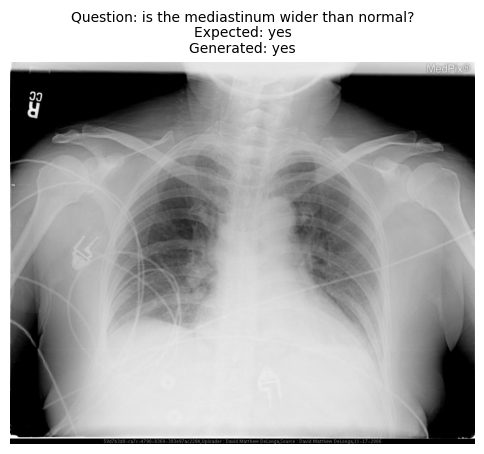

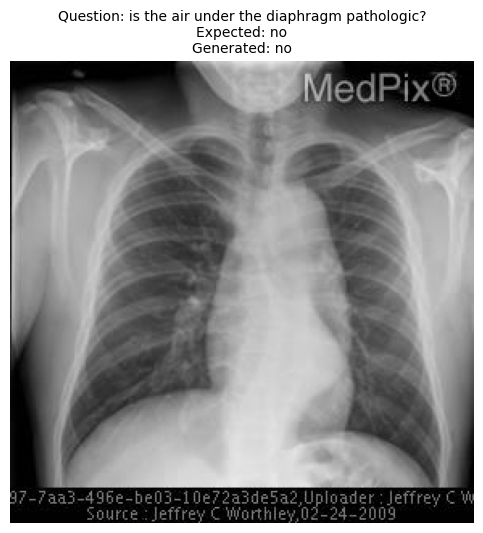

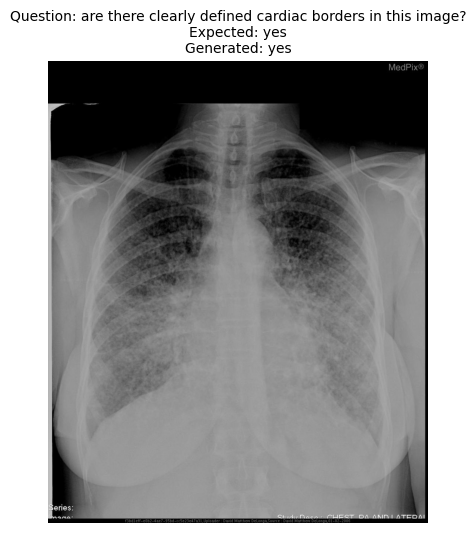

In [ ]:
 import random

# Load the dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")

# Prepare the test dataset
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Initialize the processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("/content/Model/blip-saved-model_final").to("cuda")

# Ensure model is in evaluation mode
model.eval()

# Select three random samples from the test set
random_indices = random.sample(range(len(test_df)), 3)

# Visualize and perform inference
for idx in random_indices:
    row = test_df.iloc[idx]
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to("cuda")

    # Perform inference
    with torch.no_grad():
        outputs = model.generate(**encoding)
    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Question: {question}\nExpected: {actual_answer}\nGenerated: {generated_text}", fontsize=10)
    plt.show()

## **Saving test images**

In [ ]:
# Create a folder in /content/sample_data/ for storing images
output_folder = '/content/sample_data/images'
os.makedirs(output_folder, exist_ok=True)

# Save the images in the folder
for idx in random_indices:
    row = test_df.iloc[idx]
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

    # Save the image with a unique name
    image_path = os.path.join(output_folder, f'image_{idx}.png')
    image.save(image_path)

print(f"Images have been saved to: {output_folder}")


Images have been saved to: /content/sample_data/images


# **Training of BLIP on MedIR roco - Image Captioning**

##Importing all relevant packages

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
import torch.optim as optim
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import evaluate
import torchvision.transforms as transforms

## Preparing data for training

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration
# Load the dataset
dataset = load_dataset("MedIR/roco")

# Check available splits
print("Available splits:", dataset.keys())

# Since only 'test' split is available, use it for training and validation
test_split = dataset['test']

# Verify the number of samples in 'test' split
print(f"Total samples in 'test' split: {len(test_split)}")

# Ensure there are enough samples
required_samples = 1500 + 300
if len(test_split) < required_samples:
    raise ValueError(f"The 'test' split contains only {len(test_split)} samples, but {required_samples} are required for training and validation.")

# Shuffle the dataset with a fixed seed for reproducibility
test_split = test_split.shuffle(seed=42)

# Select 1,500 samples for training and 300 for validation
train_size = 1500
val_size = 300
train_dataset = test_split.select(range(train_size))
val_dataset = test_split.select(range(train_size, train_size + val_size))

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

README.md:   0%|          | 0.00/498 [00:00<?, ?B/s]

(…)-00000-of-00001-1ca3285a8d47f6c4.parquet:   0%|          | 0.00/168M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/8176 [00:00<?, ? examples/s]

Available splits: dict_keys(['test'])
Total samples in 'test' split: 8176
Training samples: 1500
Validation samples: 300


In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        caption = item["caption"]

        if self.transform:
            image = self.transform(image)

        encoding = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=50,
            return_tensors="pt"
        )


        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding




In [ ]:
# Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

## Preparing the training setup

In [ ]:
# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# Create Dataset objects
train_data = ImageCaptioningDataset(train_dataset, processor)
val_data = ImageCaptioningDataset(val_dataset, processor)

# Create DataLoaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=8)

print("DataLoaders are set up successfully.")

DataLoaders are set up successfully.


In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Training parameters
learning_rate = 1e-5
num_epochs = 50
patience = 5  # For early stopping

# Initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Training on device: {device}")

Training on device: cuda


In [ ]:
import evaluate

# Initialize metrics
bleu = evaluate.load('bleu')
meteor = evaluate.load('meteor')
rouge = evaluate.load('rouge')

# Note: CIDEr has been removed as per your request.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
best_bleu = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch.pop("input_ids").to(device)
        attention_mask = batch.pop("attention_mask").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=input_ids
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_losses = []
    references = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch.pop("input_ids").to(device)
            attention_mask = batch.pop("attention_mask").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                labels=input_ids
            )

            loss = outputs.loss
            val_losses.append(loss.item())

            # Generate captions
            generated_ids = model.generate(
                pixel_values=pixel_values,
                max_length=50,
                num_beams=5,  # Beam search for better captions
                early_stopping=True
            )
            generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
            reference_captions = processor.batch_decode(input_ids, skip_special_tokens=True)

            predictions.extend(generated_captions)
            references.extend(reference_captions)

    avg_val_loss = np.mean(val_losses)

    # Prepare references for evaluation
    references_formatted = [[ref] for ref in references]

    # Compute evaluation metrics
    bleu_score = bleu.compute(predictions=predictions, references=references_formatted)['bleu']
    meteor_score = meteor.compute(predictions=predictions, references=references_formatted)['meteor']
    rouge_score = rouge.compute(predictions=predictions, references=references_formatted)['rougeL']

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print(f"METEOR Score: {meteor_score:.4f}")
    print(f"ROUGE-L Score: {rouge_score:.4f}")

    # Early stopping based on BLEU score
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        epochs_no_improve = 0
        model.save_pretrained("best_blip_model")
        processor.save_pretrained("best_blip_model")
        print("New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in BLEU score for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50


Training: 100%|██████████| 188/188 [03:57<00:00,  1.26s/it]


Average Training Loss: 6.1360


Validation: 100%|██████████| 38/38 [05:12<00:00,  8.22s/it]


Validation Loss: 4.5965
BLEU Score: 0.0173
METEOR Score: 0.0987
ROUGE-L Score: 0.1620
New best model saved.

Epoch 2/50


Training: 100%|██████████| 188/188 [03:58<00:00,  1.27s/it]


Average Training Loss: 3.4559


Validation: 100%|██████████| 38/38 [06:34<00:00, 10.38s/it]


Validation Loss: 2.9121
BLEU Score: 0.0262
METEOR Score: 0.1215
ROUGE-L Score: 0.1677
New best model saved.

Epoch 3/50


Training: 100%|██████████| 188/188 [03:58<00:00,  1.27s/it]


Average Training Loss: 2.4509


Validation: 100%|██████████| 38/38 [06:59<00:00, 11.05s/it]


Validation Loss: 2.5970
BLEU Score: 0.0279
METEOR Score: 0.1170
ROUGE-L Score: 0.1485
New best model saved.

Epoch 4/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 2.1145


Validation: 100%|██████████| 38/38 [06:14<00:00,  9.85s/it]


Validation Loss: 2.4993
BLEU Score: 0.0225
METEOR Score: 0.1338
ROUGE-L Score: 0.1568
No improvement in BLEU score for 1 epoch(s).

Epoch 5/50


Training: 100%|██████████| 188/188 [03:58<00:00,  1.27s/it]


Average Training Loss: 1.8730


Validation: 100%|██████████| 38/38 [06:53<00:00, 10.87s/it]


Validation Loss: 2.4645
BLEU Score: 0.0267
METEOR Score: 0.1348
ROUGE-L Score: 0.1496
No improvement in BLEU score for 2 epoch(s).

Epoch 6/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 1.6608


Validation: 100%|██████████| 38/38 [06:56<00:00, 10.97s/it]


Validation Loss: 2.4625
BLEU Score: 0.0226
METEOR Score: 0.1308
ROUGE-L Score: 0.1489
No improvement in BLEU score for 3 epoch(s).

Epoch 7/50


Training: 100%|██████████| 188/188 [03:58<00:00,  1.27s/it]


Average Training Loss: 1.4715


Validation: 100%|██████████| 38/38 [06:17<00:00,  9.92s/it]


Validation Loss: 2.5042
BLEU Score: 0.0272
METEOR Score: 0.1417
ROUGE-L Score: 0.1647
No improvement in BLEU score for 4 epoch(s).

Epoch 8/50


Training: 100%|██████████| 188/188 [03:58<00:00,  1.27s/it]


Average Training Loss: 1.2754


Validation: 100%|██████████| 38/38 [06:57<00:00, 10.98s/it]


Validation Loss: 2.5197
BLEU Score: 0.0309
METEOR Score: 0.1387
ROUGE-L Score: 0.1515
New best model saved.

Epoch 9/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 1.0821


Validation: 100%|██████████| 38/38 [06:28<00:00, 10.21s/it]


Validation Loss: 2.5677
BLEU Score: 0.0199
METEOR Score: 0.1221
ROUGE-L Score: 0.1363
No improvement in BLEU score for 1 epoch(s).

Epoch 10/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 0.9082


Validation: 100%|██████████| 38/38 [06:45<00:00, 10.66s/it]


Validation Loss: 2.6225
BLEU Score: 0.0303
METEOR Score: 0.1455
ROUGE-L Score: 0.1569
No improvement in BLEU score for 2 epoch(s).

Epoch 11/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 0.7489


Validation: 100%|██████████| 38/38 [07:10<00:00, 11.32s/it]


Validation Loss: 2.6934
BLEU Score: 0.0249
METEOR Score: 0.1432
ROUGE-L Score: 0.1473
No improvement in BLEU score for 3 epoch(s).

Epoch 12/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 0.6006


Validation: 100%|██████████| 38/38 [07:04<00:00, 11.17s/it]


Validation Loss: 2.7362
BLEU Score: 0.0295
METEOR Score: 0.1406
ROUGE-L Score: 0.1519
No improvement in BLEU score for 4 epoch(s).

Epoch 13/50


Training: 100%|██████████| 188/188 [03:59<00:00,  1.27s/it]


Average Training Loss: 0.4743


Validation: 100%|██████████| 38/38 [06:42<00:00, 10.59s/it]


Validation Loss: 2.7995
BLEU Score: 0.0241
METEOR Score: 0.1405
ROUGE-L Score: 0.1475
No improvement in BLEU score for 5 epoch(s).
Early stopping triggered.


## Saving fine-tuned model

In [ ]:
# Load the best model
best_model_path = "best_blip_model"
model = BlipForConditionalGeneration.from_pretrained(best_model_path)
processor = AutoProcessor.from_pretrained(best_model_path)
model.to(device)
model.eval()

print("Best model loaded successfully.")


Best model loaded successfully.


## Testing

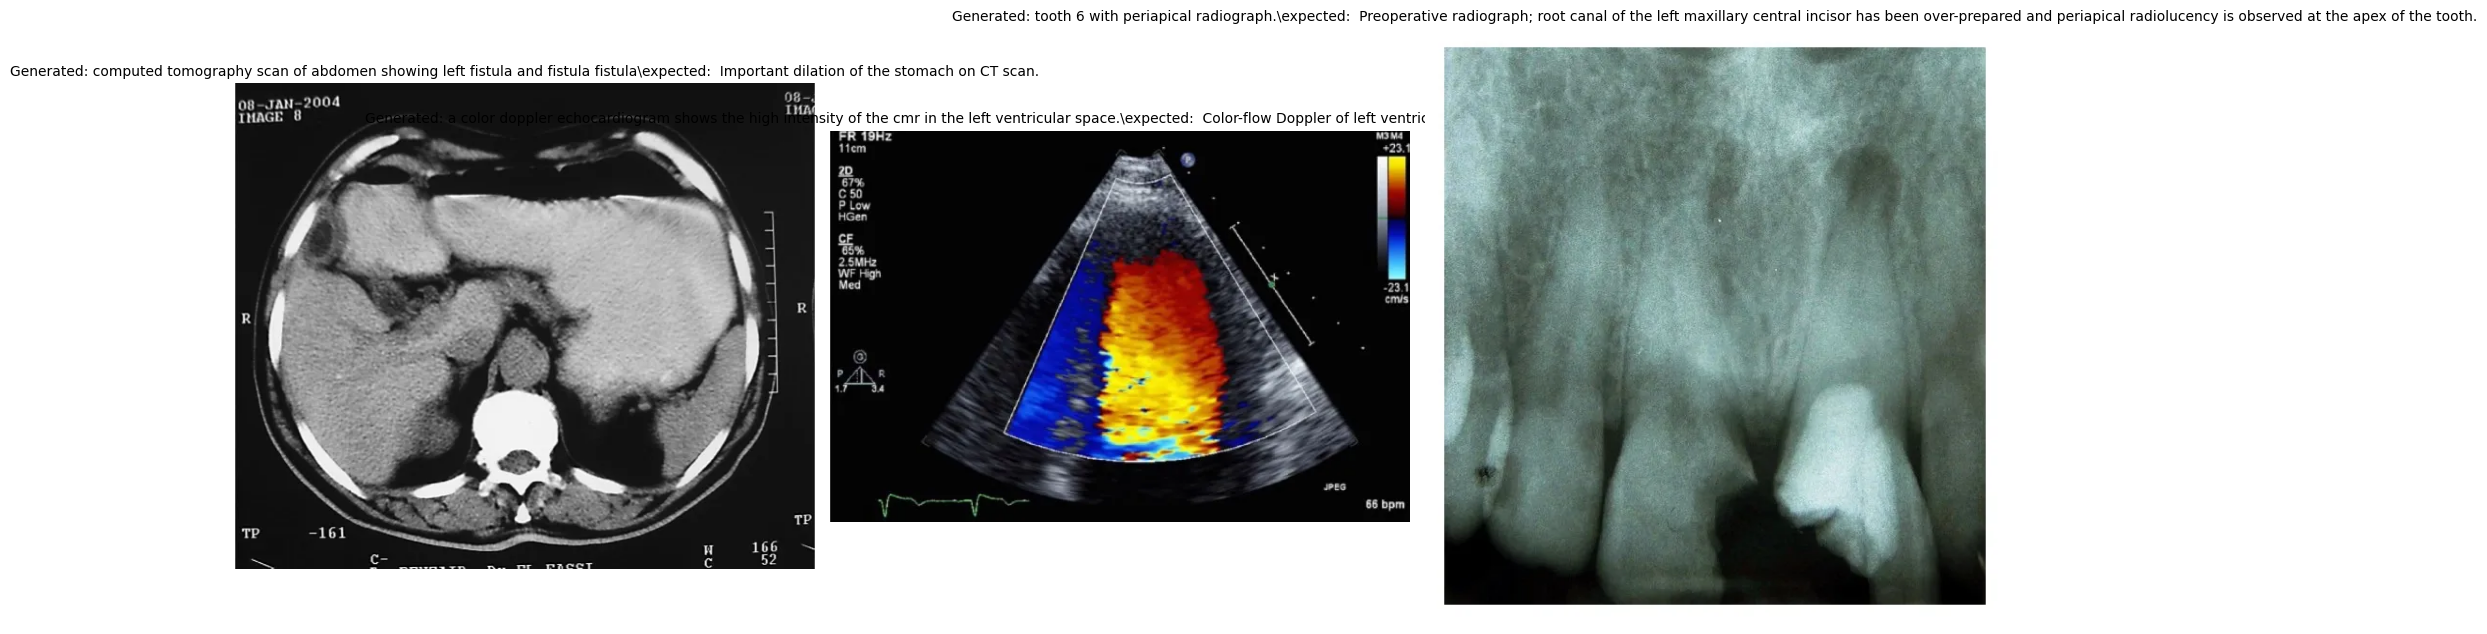

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
fig = plt.figure(figsize=(18, 14))

model.eval()
with torch.no_grad():
    for i in range(3):  # Loop through the first 6 samples
        example = val_dataset[i]  # Access the i-th example
        image = example["image"]
        reference_caption = example["caption"]

        # Process the image for the model
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        # Generate caption
        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Add subplot for each image
        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Generated: {generated_caption}\expected: {reference_caption}", fontsize=10)

plt.tight_layout()
plt.show()

Image: image_35.png
Generated Caption: chest radiograph showing bilateral pulmonary edema.



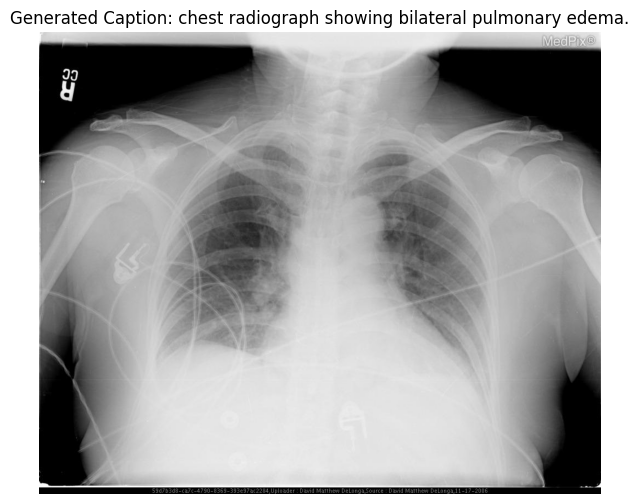

Image: image_112.png
Generated Caption: chest x - ray showing diffuse, diffuse, and atrial pneumothorax



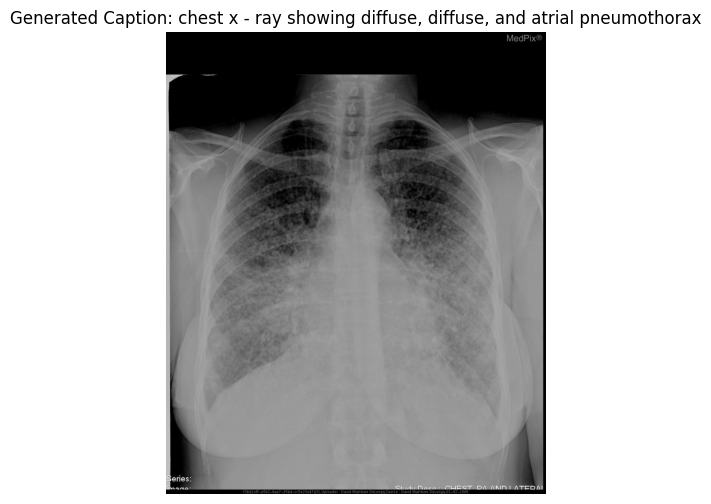

Image: image_150.png
Generated Caption: chest x - ray showing chest pneumoperitoneum



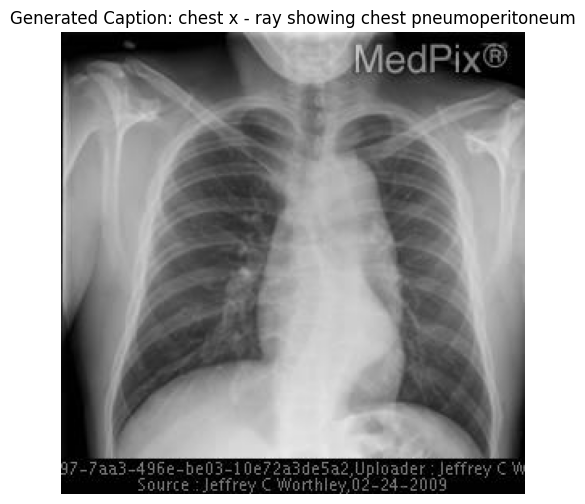

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Function to load and process an image
def load_image(image_path):
    """
    Loads an image from the specified path and converts it to RGB.

    Args:
        image_path (str): The file path to the image.

    Returns:
        PIL.Image.Image: The loaded image in RGB format, or None if loading fails.
    """
    try:
        return Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Function to generate a caption for a single image
def generate_caption(image):
    """
    Generates a caption for the given image using the trained BLIP model.

    Args:
        image (PIL.Image.Image): The image for which to generate a caption.

    Returns:
        str: The generated caption.
    """
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

# Specify the path to the folder containing your images
# Replace the string below with the actual path to your image folder
folder_path = "/content/sample_data/images"  # Example: "/content/images"

# Supported image file extensions
supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Retrieve a list of image files in the specified folder
try:
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(supported_formats)]
except FileNotFoundError:
    print(f"The folder path '{folder_path}' does not exist. Please provide a valid path.")
    image_files = []

# Check if there are at least 3 images in the folder
if len(image_files) < 3:
    print(f"Found {len(image_files)} image(s) in '{folder_path}'. Please ensure there are at least 3 images.")
else:
    # Select the first 3 images
    selected_images = image_files[:3]

    for img_file in selected_images:
        img_path = os.path.join(folder_path, img_file)
        image = load_image(img_path)

        if image:
            caption = generate_caption(image)
            print(f"Image: {img_file}")
            print(f"Generated Caption: {caption}\n")

            # Display the image with its caption
            plt.figure(figsize=(8,6))
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Generated Caption: {caption}")
            plt.show()
        else:
            print(f"Skipping image {img_file} due to loading issues.\n")



## **Refrences**

[Finetuning Blip on patholgy dataset](https://github.com/slinusc/path-vqa-blip/tree/main)

[Finetunnig Blip on medicalRad dataset ](https://github.com/Adibvafa/RadioCareBorealisAI)

[Fine-tune BLIP using Hugging Face transformers and datasets](https://colab.research.google.com/drive/1lbqiSiA0sDF7JDWPeS0tccrM85LloVha?usp=sharing)